Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1/1 [==============================] - 1s 711ms/step


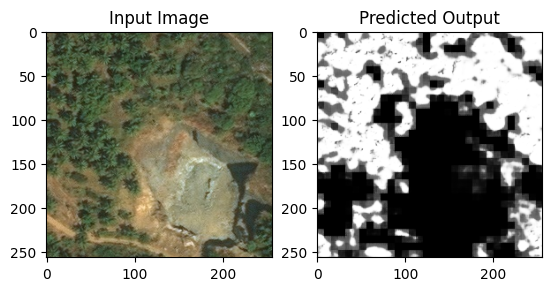

In [57]:
from google.colab import drive
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Load the U-Net Model
model = keras.models.load_model('/content/drive/MyDrive/unet_customdataset.h5')

# Load and preprocess the input image
#image_path = '/content/drive/MyDrive/Sowmik Dataset/Planned_way/Park all processed data/Preprocessed park/banff park 2020.jpg'
image_path = '/content/drive/MyDrive/images/111335_sat_02.jpg'

input_width, input_height = 256, 256  # Replace with your model's input size
input_image = Image.open(image_path)
input_image = input_image.resize((input_width, input_height))
#input_image = np.array(input_image) / 255.0
input_image = np.expand_dims(input_image, axis=0)

# Make predictions
predictions = model.predict(input_image)

# Display input image
plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(input_image[0])

# Display predicted output (assuming it's a segmentation map)
plt.subplot(1, 2, 2)
plt.title('Predicted Output')
plt.imshow(predictions[0, :, :, 0], cmap='gray')  # Adjust cmap based on your output

plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split

# Define paths to your image and mask directories
image_dir = '/content/drive/MyDrive/komimages'
mask_dir = '/content/drive/MyDrive/kommasks'

# List all image and mask file paths
image_paths = sorted([os.path.join(image_dir, filename) for filename in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, filename) for filename in os.listdir(mask_dir)])

# Shuffle the list of image and mask paths to mix positives and negatives
combined = list(zip(image_paths, mask_paths))
random.shuffle(combined)
image_paths, mask_paths = zip(*combined)




In [4]:
# Function to load and preprocess an image and mask
def load_and_preprocess(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize the image and mask to your desired dimensions
    image = cv2.resize(image, (224, 224))
    mask = cv2.resize(mask, (224, 224))

    # Normalize image pixel values to the range [0, 1]
    image = image / 255.0

    # Create a binary label: 1 for similar (green) and 0 for dissimilar (non-green)
    label = int(np.max(mask) > 0)

    return image, label



In [5]:
# Split the dataset into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42)



In [6]:
# Create pairs of images and labels for training and validation
train_pairs = [(load_and_preprocess(image_path, mask_path), load_and_preprocess(image_path, mask_path))
               for image_path, mask_path in zip(train_image_paths, train_mask_paths)]

val_pairs = [(load_and_preprocess(image_path, mask_path), load_and_preprocess(image_path, mask_path))
             for image_path, mask_path in zip(val_image_paths, val_mask_paths)]

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the base convolutional neural network (CNN) for Siamese twins
def create_base_network(input_shape):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
    ])
    return model

# Define the Siamese network
def create_siamese_network(input_shape):
    input_a = keras.Input(shape=input_shape)
    input_b = keras.Input(shape=input_shape)

    base_network = create_base_network(input_shape)

    embedding_a = base_network(input_a)
    embedding_b = base_network(input_b)

    # Calculate L1 distance between embeddings
    distance = tf.keras.layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([embedding_a, embedding_b])

    model = keras.Model(inputs=[input_a, input_b], outputs=distance)
    return model


In [8]:
input_shape = (224, 224, 3)  # Adjust based on your image size
siamese_model = create_siamese_network(input_shape)

# Define a contrastive loss function
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    return tf.reduce_mean(y_true * tf.square(y_pred) + (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0)))

siamese_model.compile(loss=contrastive_loss, optimizer='adam')


In [9]:
train_images, train_labels = zip(*train_pairs)
train_images_a, train_images_b = zip(*train_images)
train_labels = np.array(train_labels)

val_images, val_labels = zip(*val_pairs)
val_images_a, val_images_b = zip(*val_images)
val_labels = np.array(val_labels)

batch_size = 32
num_epochs = 10



<ipython-input-9-ca458f61cd95>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_labels = np.array(train_labels)
<ipython-input-9-ca458f61cd95>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_labels = np.array(val_labels)


In [13]:
history = siamese_model.fit(
    [tf.convert_to_tensor(train_images_a), tf.convert_to_tensor(train_images_b)],
    tf.convert_to_tensor(train_labels),
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=([tf.convert_to_tensor(val_images_a), tf.convert_to_tensor(val_images_b)], tf.convert_to_tensor(val_labels))
)


ValueError: ignored

In [53]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Adjust the input size for the first fully connected layer
        cnn_output_size = (128, 30, 30)
        input_size_fc = cnn_output_size[0] * cnn_output_size[1] * cnn_output_size[2]

        self.fc = nn.Sequential(
            nn.Linear(input_size_fc, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.Linear(256, 2)
        )

    # The rest of your SiameseNetwork class remains the same.


    def forward_one(self, x):
        x = self.cnn(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2




class CustomDataset(Dataset):
    def __init__(self, image_folder, mask_folder):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_files = os.listdir(image_folder)
        self.mask_files = [os.path.join(mask_folder, f'mask_{file}') for file in self.image_files]
        self.transform = transforms.Compose([transforms.ToTensor()])

    def __getitem__(self, index):
        image_path = os.path.join(self.image_folder, self.image_files[index])
        mask_path = self.mask_files[index]  # Use the corresponding mask filename

        image = Image.open(image_path)
        mask = Image.open(mask_path)

        image = self.transform(image)
        mask = self.transform(mask)

        # Define labels (0 for dissimilar pairs, 1 for similar pairs)
        label = 0 if "mask_" in self.image_files[index] else 1

        return image, mask, label

    def __len__(self):
        return len(self.image_files)






In [54]:
# Training the Siamese network
def train_siamese_network(siamese_net, dataloader, num_epochs=10, learning_rate=0.001):
    siamese_net.train()

    criterion = ContrastiveLoss()
    optimizer = optim.Adam(siamese_net.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader, 0):
            input1, input2, label = data
            optimizer.zero_grad()
            output1, output2 = siamese_net(input1, input2)
            loss = criterion(output1, output2, label)
            loss.backward()
            optimizer.step()
            print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {loss.item()}")





In [55]:
# Set up the data and train the Siamese network
if __name__ == '__main__':
    image_folder = '/content/drive/MyDrive/komimages'
    mask_folder = '/content/drive/MyDrive/kommasks'
    dataset = CustomDataset(image_folder, mask_folder)
    dataloader = DataLoader(dataset, shuffle=True, batch_size=64)

    siamese_net = SiameseNetwork()

    train_siamese_network(siamese_net, dataloader, num_epochs=10, learning_rate=0.001)

RuntimeError: ignored